<a href="https://colab.research.google.com/github/pythonuzgit/elmurodov/blob/master/Computer%20Vision/glass_hiring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56439 sha256=483b37b75b485e7a329d03499130d91eb536e099b318e3ec2c328dfd7b5b0ff2
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"uzazam","key":"7abb2778b77e603b3a87069f481fc6a6"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#change the permission

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d piyush1089/glass-hiring

 98% 808M/826M [00:11<00:00, 81.5MB/s]
100% 826M/826M [00:11<00:00, 74.1MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "/content/glass-hiring.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import datetime as dt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('darkgrid')

import os
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import cv2
from scipy.stats import uniform

from tqdm import tqdm
from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

import keras
from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Masking,GlobalAveragePooling1D
#from keras.utils import np_utils, to_categorical
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img



from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
base_folder = '/content/dataset'
train_folder = '/content/dataset/train'
test_folder = '/content/dataset/test'

In [ ]:
#read the image attributes csv file
df = pd.read_csv('/content/dataset/train.csv')
df.head()

,image_ID,label
0,7c225f7b61.jpg,Badminton
1,b31.jpg,Badminton
2,acb146546c.jpg,Badminton
3,0e62f4d8f2.jpg,Badminton
4,cfd2c28c74.jpg,Cricket


In [ ]:
# Make a numerical column for club memership for plotting by networkx
# 0 - Mr. Hi; 1 - Officer
df['label'] = df['label'].replace(['Badminton', 'Cricket', 'Wrestling',
                                   'Tennis', 'Karate', 'Soccer', 'Swimming'], [0, 1, 2, 3, 4, 5, 6])

In [ ]:
df.head()

,image_ID,label
0,7c225f7b61.jpg,0
1,b31.jpg,0
2,acb146546c.jpg,0
3,0e62f4d8f2.jpg,0
4,cfd2c28c74.jpg,1


<Axes: >

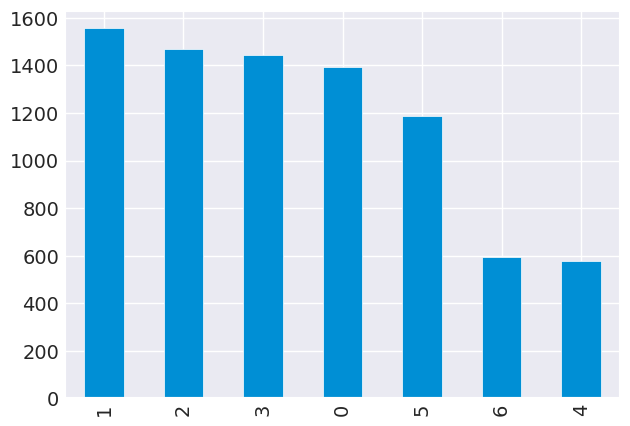

In [ ]:
df.label.value_counts().plot(kind="bar")

In [ ]:
SAMPLES = 300
train_data = pd.concat([df[df['label']== i][:SAMPLES] for i in range(0,2)])
print('TRAIN DATA SHAPE: ', train_data.shape)

TRAIN DATA SHAPE:  (600, 2)


SHOW SAMPLE IMAGES

In [ ]:
# function to get an image
def read_img(image_ID, size):
  img = image.load_img(os.path.join(train_folder, image_ID), target_size=size)
  #convert image to array
  img = image.img_to_array(img) / 255
  return img

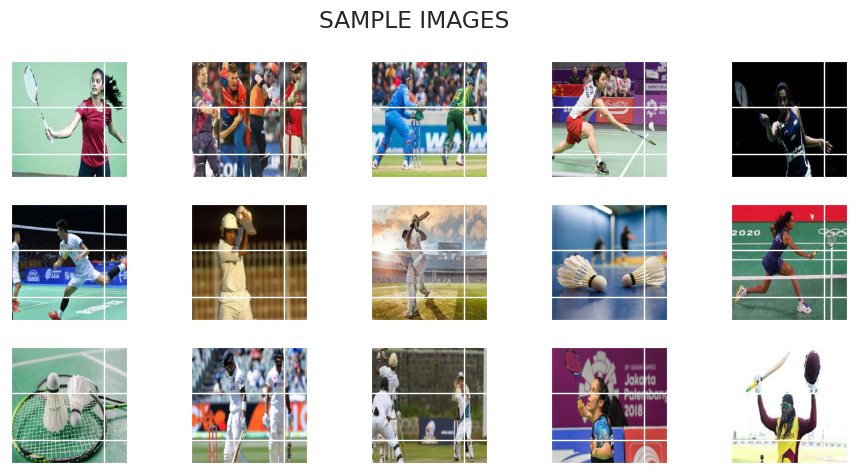

In [ ]:
nb_rows = 3
nb_cols = 5
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 5));
plt.suptitle('SAMPLE IMAGES');
for i in range(0, nb_rows):
  for j in range(0, nb_cols):
    axs[i, j].xaxis.set_ticklabels([]);
    axs[i, j].yaxis.set_ticklabels([]);
    axs[i, j].imshow((read_img(train_data['image_ID'].iloc[np.random.randint(500)], (255,255))));

plt.show();

DATA AUGMENTATION

In [ ]:
#create a imagegenerator for for augmentation
datagen =  ImageDataGenerator(
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

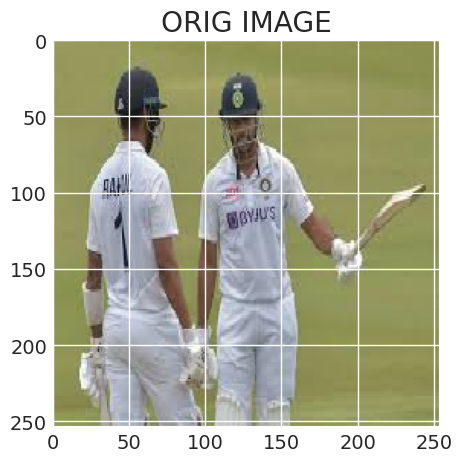

In [ ]:
img = read_img(train_data['image_ID'].iloc[546], (255,255))
plt.title('ORIG IMAGE')
plt.imshow(img);

SHOW SAMPLE AUGMENTED IMAGE

In [ ]:
# reshape image to 4 dimentional
img = img.reshape((1,) + img.shape)

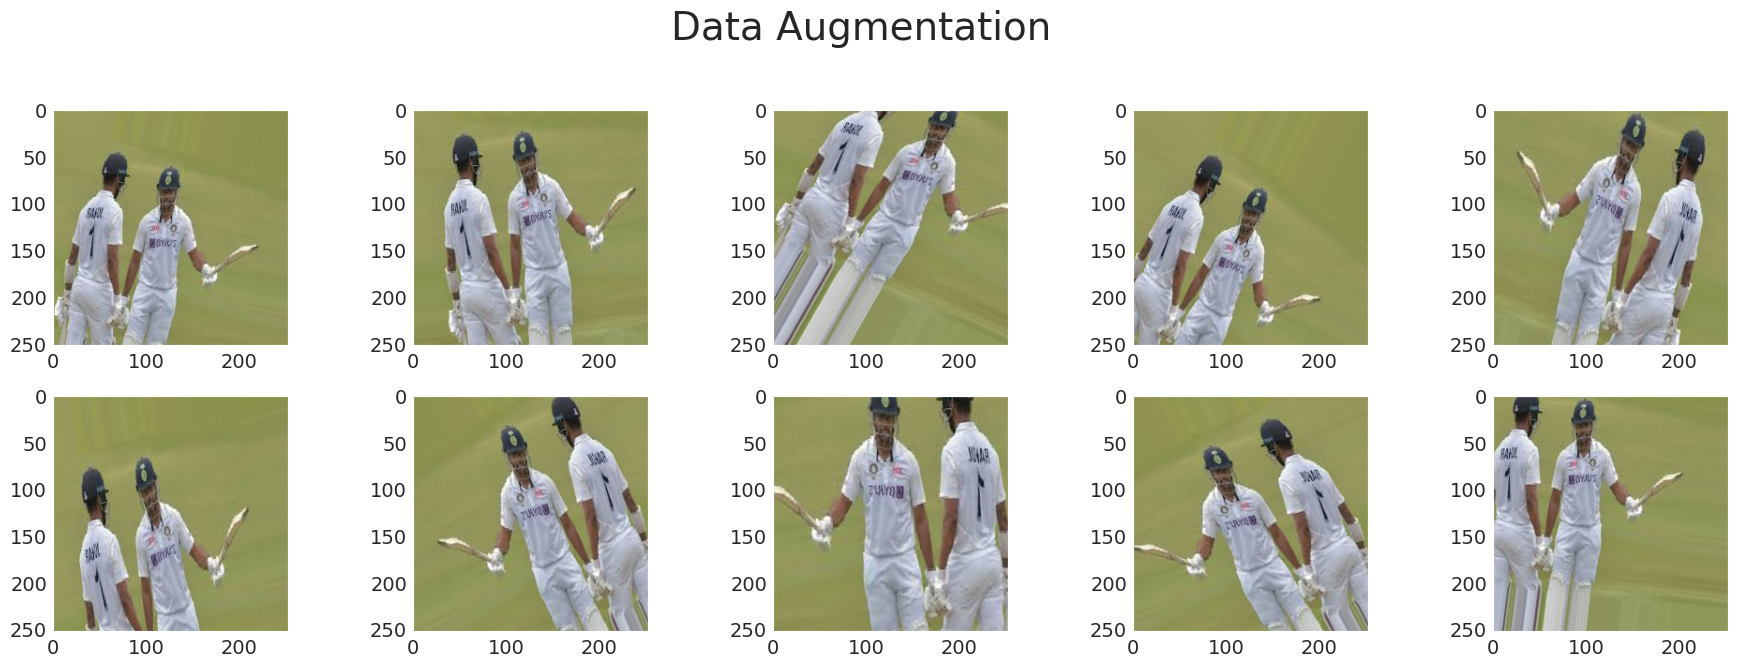

In [ ]:
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)


i = 0

for batch in datagen.flow(img, batch_size=32):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow(batch.reshape(255, 255, 3));

    if i == 9:
        break
    i += 1

plt.show();

In [ ]:
X = train_data.drop(['label'], axis=1)
y = train_data['label']

train_x, train_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=101)

IMAGE PROCESSING

In [ ]:
# function to get an image
def read_img(image_ID, size):
    img = image.load_img(os.path.join(train_folder, image_ID), target_size=size)
    #convert image to array
    img = image.img_to_array(img) / 255
    img = img.reshape((1,) + img.shape)
    return img



array_img = []
label_img = []

for i, file in tqdm(enumerate(train_x['image_ID'])):
    img = read_img(file, (255,255))
    label = y_train.iloc[i]
    num = 0
    for batch in datagen.flow(img, batch_size=32):
        batch = batch.reshape(255,255,3)
        array_img.append(batch)
        label_img.append(label)
        if num == 4:
            break
        num=num+1

480it [00:47, 10.14it/s]


XCEPTION INPUT PREPROCESSING

In [ ]:
#preprocess train
INPUT_SIZE = 255

X_train = np.zeros((len(array_img), INPUT_SIZE, INPUT_SIZE, 3), dtype='float')
i=0
for file in tqdm(array_img):
    X_train[i] = xception.preprocess_input(np.expand_dims(file.copy(), axis=0))
    i = i+1

100%|██████████| 2400/2400 [00:03<00:00, 611.89it/s]


In [ ]:
#preprocess validation
X_val = np.zeros((len(train_val), INPUT_SIZE, INPUT_SIZE, 3), dtype='float')
for i, file in tqdm(enumerate(train_val['image_ID'])):
    img = read_img(file, (255,255))
    X_val[i] = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))

120it [00:00, 149.57it/s]


BOTTLENECK FEATURE EXTRACTION

In [ ]:
xception_bf = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
bf_train_x = xception_bf.predict(X_train, batch_size=32, verbose=1)
bf_train_val = xception_bf.predict(X_val, batch_size=32, verbose=1)

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
#print shape of feature and size
print('Train Shape: ', bf_train_x.shape)
print('Train Size: ', bf_train_x.size)

print('Validation Shape: ', bf_train_val.shape)
print('Validation Size: ', bf_train_val.size)

MODELLING

In [ ]:
#keras model
model = Sequential()
model.add(Dense(units = 512 , activation = 'relu', input_dim=bf_train_x.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer ='adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

In [ ]:
#set callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
         ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

#fit the data
history = model.fit(bf_train_x, np.array(label_img), batch_size=32, epochs=100, callbacks=callbacks)

LOSS AND ACCURACY

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].set_title('TRAINING LOSS');
ax[1].set_title('TRAINING ACCURACY');


ax[0].plot(history.history['loss'], color= 'salmon',lw=2);
ax[1].plot(history.history['accuracy'], color= 'steelblue',lw=2);

In [ ]:
#predict the validation data
predictions = model.predict_classes(bf_train_val)

CLASSIFICATION REPORT

In [ ]:
print(classification_report(y_val, predictions))

CONFUSION MATRIX

In [ ]:
con_mat = confusion_matrix(y_val, predictions)
plt.figure(figsize=(5,5))

sns.heatmap(con_mat, annot=True, square=True);
plt.xlabel('Y_TRUE');
plt.ylabel('PREDICTIONS');